In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil, pickle, shelve
from Bio import SeqIO
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model, Model
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten, Conv1D, LSTM, CuDNNLSTM, Bidirectional, TimeDistributed
from keras.optimizers import RMSprop, Adam
from keras.initializers import glorot_normal
from utilities import sampling, one_hot_encoding, curtail, get_training_data, load_data, data_split, dianostic_plots, pad_for_detector
from utilities import get_char_list, get_freqs, get_candidates, get_motif
import keras
import utilities

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.


In [3]:
# Subset sampling: save to me_samples; "me" for "mutually exclusive"
output_folder_path = "../../../../temp/buffers/me_samples"

data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"

len(os.listdir(data_dir)) # total number of regions

3543

Uncomment the following code chunk to resample training and validation data

In [7]:
# !rm -r /home/ubuntu/data/temp/train
# !mkdir /home/ubuntu/data/temp/train
# !rm -r /home/ubuntu/data/temp/val
# !mkdir /home/ubuntu/data/temp/val

# ###############################################################################
# # Sample training and validation data
# # IMPORTANT: Make sure that training and validation don't have intersection!!!
# ###############################################################################
# all_data_lst = np.array(os.listdir(data_dir))
# n = len(all_data_lst)
# num_trained_regions = int(n * 0.8)
# train_files = all_data_lst[:num_trained_regions]
# num_val = n - num_trained_regions
# val_indices = np.random.choice(np.arange(num_trained_regions, n), num_val, replace = False)
# val_files = all_data_lst[val_indices]

# train_dest = '/home/ubuntu/data/temp/train/'
# for file in train_files:
#     shutil.copy(os.path.join(data_dir, file),
#                           train_dest)
# print('copied training samples to {}'.format(train_dest))

# val_dest = '/home/ubuntu/data/temp/val/'
# for file in val_files:
#     shutil.copy(os.path.join(data_dir, file),
#                           val_dest)
# print('copied validation samples to {}'.format(val_dest))

# # Preprocess train and val data so that they are ready to be fed to models
# train_output_path = os.path.join(output_folder_path, 'train.data')
# val_output_path = os.path.join(output_folder_path, 'val.data')

# train_regions = one_hot_encoding(train_dest, train_output_path)
# val_regions = one_hot_encoding(val_dest, val_output_path)
# train_x, train_y = get_training_data(train_regions, output_folder_path,
#                                    max_len = 1000, 
#                                    train_x_name = 'train_x.data', 
#                                    train_y_name = 'train_y.data')
# val_x, val_y = get_training_data(val_regions, output_folder_path,
#                                    max_len = 1000, 
#                                    train_x_name = 'val_x.data', 
#                                    train_y_name = 'val_y.data')
# # Pad for motif detectors
# train_x, val_x = pad_for_detector(train_x, 15), pad_for_detector(val_x, 15)

copied training samples to /home/ubuntu/data/temp/train/
copied validation samples to /home/ubuntu/data/temp/val/
save to ../../../../temp/buffers/me_samples/train.data
save to ../../../../temp/buffers/me_samples/val.data
(68016, 1000, 4) (68016,)
save to ../../../../temp/buffers/me_samples/train_x.data
save to ../../../../temp/buffers/me_samples/train_y.data
(17016, 1000, 4) (17016,)
save to ../../../../temp/buffers/me_samples/val_x.data
save to ../../../../temp/buffers/me_samples/val_y.data


NameError: name 'pad_for_detector' is not defined

In [ ]:
# data_x = pickle.load(open('../../../../temp/buffers/ss_samples/train_x.data', 'rb'))
# data_y = pickle.load(open('../../../../temp/buffers/ss_samples/train_y.data', 'rb'))
# train_x, train_y, val_x, val_y = data_split(data_x, data_y, seed = 157)
# train_x, val_x = pad_for_detector(train_x, 10), pad_for_detector(val_x, 10)

In [4]:
train_x = pickle.load(open(os.path.join(output_folder_path, 'train_x.data'), 'rb'))
train_y = pickle.load(open(os.path.join(output_folder_path, 'train_y.data'), 'rb'))
val_x = pickle.load(open(os.path.join(output_folder_path, 'val_x.data'), 'rb'))
val_y = pickle.load(open(os.path.join(output_folder_path, 'val_y.data'), 'rb'))

In [5]:
n = 30 # number of filters
m = 10 # filter size
train_x, val_x = pad_for_detector(train_x, m), pad_for_detector(val_x, m)

In [21]:
def get_hybrid(opt, num_filters, kernel_size):
    """  Return a hybrid network given a optimizer
    """
    model = Sequential()
    model.add(Conv1D(filters = num_filters, 
                     kernel_size = kernel_size, 
                     padding = 'valid',
                     activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 5, strides = 5))
    model.add(Dropout(0.1))
    #model.add(Bidirectional(LSTM(20)))
    model.add(Bidirectional(CuDNNLSTM(15, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(10)))
    model.add(Dropout(0.2))
    model.add(Dense(50))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dense(20))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    return model


def train(model, train_x, train_y, val_data, config = {'epochs': 35, 'batch_size': 256}):
    """  Train model for a given config, training data, and validation data
    """
    epochs, batch_size = config['epochs'], config['batch_size']
    return model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=val_data)

In [28]:
# Start training
# Set up some configurations
optimizers = {'adam': Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-2, amsgrad=False),
              'rmsprop': RMSprop(lr=1e-2, rho=0.9, epsilon=None, decay=1e-2)}
config = {'epochs': 100, 'batch_size': 562}
opt = optimizers['adam']

model = get_hybrid(opt, num_filters = n, kernel_size = m)
history = train(model, train_x, train_y, (val_x, val_y), config)

Train on 68016 samples, validate on 17016 samples
Epoch 1/100
68016/68016 [==============================] - 25s 368us/step - loss: 0.6872 - acc: 0.5505 - val_loss: 0.6835 - val_acc: 0.5275
Epoch 2/100
68016/68016 [==============================] - 23s 335us/step - loss: 0.6791 - acc: 0.5504 - val_loss: 0.6774 - val_acc: 0.5278
Epoch 3/100
68016/68016 [==============================] - 23s 335us/step - loss: 0.6771 - acc: 0.5514 - val_loss: 0.6773 - val_acc: 0.5275
Epoch 4/100
68016/68016 [==============================] - 23s 335us/step - loss: 0.6767 - acc: 0.5526 - val_loss: 0.6768 - val_acc: 0.5279
Epoch 5/100
68016/68016 [==============================] - 23s 334us/step - loss: 0.6758 - acc: 0.5518 - val_loss: 0.6765 - val_acc: 0.5323
Epoch 6/100
68016/68016 [==============================] - 23s 333us/step - loss: 0.6760 - acc: 0.5520 - val_loss: 0.6760 - val_acc: 0.5352
Epoch 7/100
68016/68016 [==============================] - 22s 327us/step - loss: 0.6757 - acc: 0.5511 - val_l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



68016/68016 [==============================] - 19s 282us/step - loss: 0.6717 - acc: 0.5628 - val_loss: 0.6742 - val_acc: 0.5531
Epoch 99/100
68016/68016 [==============================] - 19s 283us/step - loss: 0.6711 - acc: 0.5609 - val_loss: 0.6742 - val_acc: 0.5532
Epoch 100/100
68016/68016 [==============================] - 19s 282us/step - loss: 0.6712 - acc: 0.5638 - val_loss: 0.6742 - val_acc: 0.5534


In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 1009, 30)          1230      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 201, 30)           0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 201, 30)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 201, 30)           5640      
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 20)                3360      
_________________________________________________________________
dropout_22 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                1050      
__________

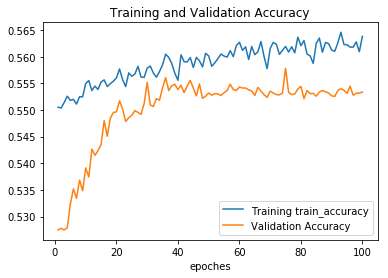

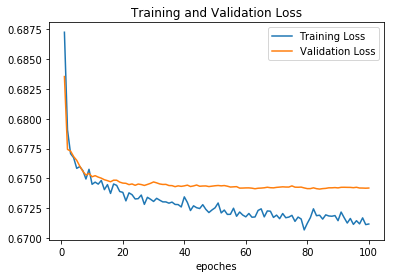

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

dianostic_plots(acc, loss, val_acc, val_loss)

In [ ]:
# Save the model for later analysis
save_model_path = '/home/ubuntu/data/team_neural_network/code/models'
model_name = 'big_hybrid_net.h5'
model.save(os.path.join(save_model_path, model_name))

In [ ]:
model = load_model('../../models/big_hybrid_net.h5')

filters = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]

In [ ]:
layer_name = model.layers[0].get_config()['name']
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(val_x)

In [ ]:
activated_subseq = get_activated_subseq(intermediate_output, val_x, m)

In [ ]:
for i in list(activated_subseq):
    char_list = get_char_list(activated_subseq[i])
    uniques, freqs = get_freqs(char_list)
    candidates = get_candidates(uniques, freqs, 0.45)
    print("*************{}**************".format(i))
    print(get_motif(candidates))
    print("*****************************\n")